Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
def decorrelate(num_epochs, data, model):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
        # model.weight -= lr * model.weight.grad
        print(f'iteration {i}\tloss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

iteration 0	loss: 0.022
iteration 1	loss: 0.020
iteration 2	loss: 0.018
iteration 3	loss: 0.017
iteration 4	loss: 0.016
iteration 5	loss: 0.014
iteration 6	loss: 0.013
iteration 7	loss: 0.012
iteration 8	loss: 0.012
iteration 9	loss: 0.011
iteration 10	loss: 0.010
iteration 11	loss: 0.009
iteration 12	loss: 0.009
iteration 13	loss: 0.008
iteration 14	loss: 0.008
iteration 15	loss: 0.007
iteration 16	loss: 0.007
iteration 17	loss: 0.007
iteration 18	loss: 0.006
iteration 19	loss: 0.006
iteration 20	loss: 0.006
iteration 21	loss: 0.005
iteration 22	loss: 0.005
iteration 23	loss: 0.005
iteration 24	loss: 0.005
iteration 25	loss: 0.004
iteration 26	loss: 0.004
iteration 27	loss: 0.004
iteration 28	loss: 0.004
iteration 29	loss: 0.004
iteration 30	loss: 0.004
iteration 31	loss: 0.004
iteration 32	loss: 0.003
iteration 33	loss: 0.003
iteration 34	loss: 0.003
iteration 35	loss: 0.003
iteration 36	loss: 0.003
iteration 37	loss: 0.003
iteration 38	loss: 0.003
iteration 39	loss: 0.003
iteration 

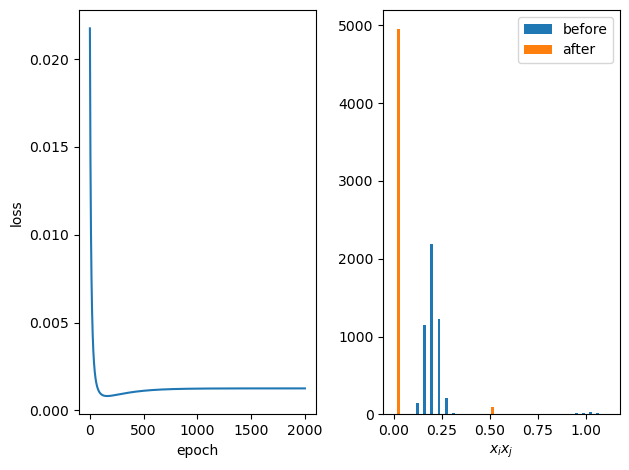

In [8]:
num_samples=1000
num_features=100
num_epochs=2000
seed=42
lr=1e-3 # huge loss spike at 1e-3

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

# create a decorrelator
model = Decorrelation(in_features=num_features, eta=lr, diagonal = 1.0) # TO DO 

L, A1, A2 = decorrelate(num_epochs, data, model) 

plt.figure()
plt.subplot(1,2,1)
plt.plot(L)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
plt.legend()
plt.xlabel('$x_i x_j$')
plt.legend();
plt.tight_layout()

Parameter containing:
tensor([[ 7.8954e-01, -1.1736e-02, -8.2890e-03,  ..., -1.1051e-02,
         -2.2112e-02, -1.1699e-02],
        [-1.2501e-02,  8.1750e-01, -6.2721e-03,  ...,  4.8374e-04,
         -2.1891e-03, -4.3145e-02],
        [-8.3646e-03, -5.6317e-03,  7.8935e-01,  ..., -1.4996e-02,
          6.6080e-03, -1.2168e-02],
        ...,
        [-1.1323e-02,  7.4232e-04, -1.5241e-02,  ...,  7.9966e-01,
          1.4470e-02, -2.7557e-02],
        [-2.3501e-02, -2.3116e-03,  6.1688e-03,  ...,  1.4294e-02,
          8.3556e-01, -8.5688e-03],
        [-1.2187e-02, -4.2611e-02, -1.2740e-02,  ..., -2.7910e-02,
         -7.9961e-03,  8.1272e-01]])

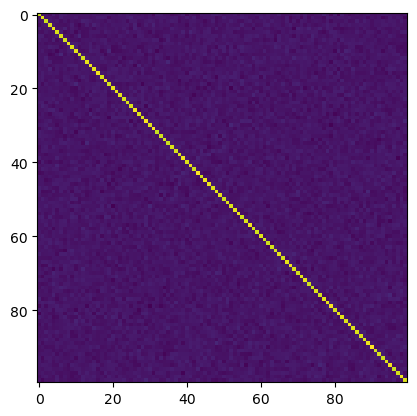

In [4]:
# we learn a lower triangular matrix
plt.imshow(model.weight.detach().numpy());
model.weight

Decorrelation of correlated input using DecorConv2d

iteration 0	loss: 0.452
iteration 1	loss: 0.150
iteration 2	loss: 0.083
iteration 3	loss: 0.059
iteration 4	loss: 0.032
iteration 5	loss: 0.032
iteration 6	loss: 0.024
iteration 7	loss: 0.024
iteration 8	loss: 0.024
iteration 9	loss: 0.021
iteration 10	loss: 0.020
iteration 11	loss: 0.020
iteration 12	loss: 0.019
iteration 13	loss: 0.018
iteration 14	loss: 0.018
iteration 15	loss: 0.018
iteration 16	loss: 0.018
iteration 17	loss: 0.017
iteration 18	loss: 0.016
iteration 19	loss: 0.016
iteration 20	loss: 0.016
iteration 21	loss: 0.015
iteration 22	loss: 0.015
iteration 23	loss: 0.015
iteration 24	loss: 0.015
iteration 25	loss: 0.014
iteration 26	loss: 0.014
iteration 27	loss: 0.014
iteration 28	loss: 0.013
iteration 29	loss: 0.013
iteration 30	loss: 0.013
iteration 31	loss: 0.013
iteration 32	loss: 0.012
iteration 33	loss: 0.012
iteration 34	loss: 0.012
iteration 35	loss: 0.012
iteration 36	loss: 0.012
iteration 37	loss: 0.011
iteration 38	loss: 0.011
iteration 39	loss: 0.011
iteration 

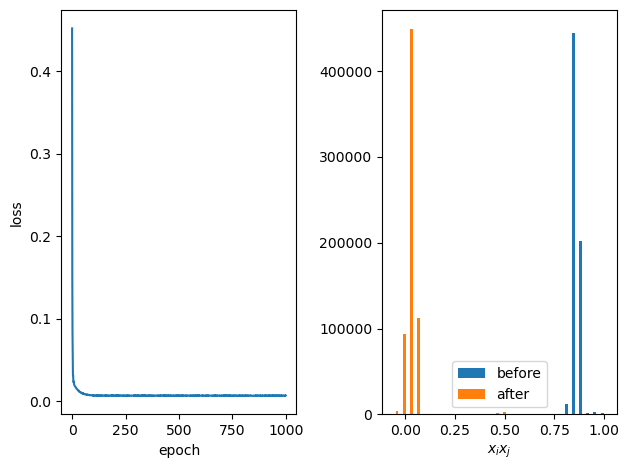

In [9]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=1000
seed=42
lr=1e-2 # huge loss spike at 1e-3
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width)

# create a convolutional decorrelator
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, eta=lr, downsample_perc=downsample_perc)

L, A1, A2 = decorrelate(num_epochs, data, model) 

plt.figure()
plt.subplot(1,2,1)
plt.plot(L)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
plt.legend()
plt.xlabel('$x_i x_j$')
plt.legend();
plt.tight_layout()

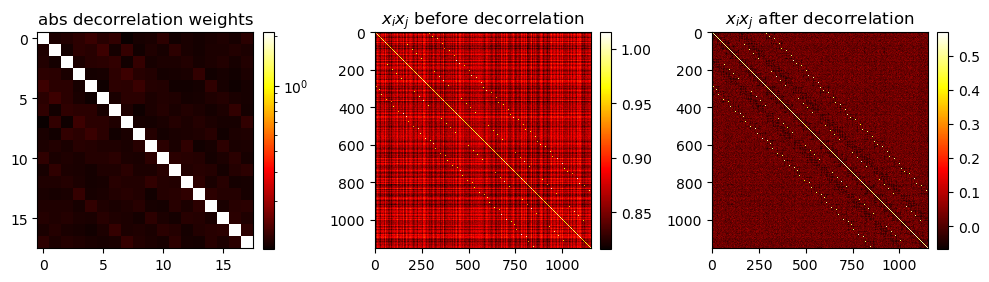

In [6]:
import matplotlib 
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
min = np.min(np.abs(model.weight.numpy().flatten()))
max = np.max(np.abs(model.weight.numpy().flatten()))
plt.imshow(np.abs(model.weight), cmap=plt.get_cmap('hot'), interpolation='nearest', norm=matplotlib.colors.LogNorm(vmin=min, vmax=max))
plt.title('abs decorrelation weights')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,3,2)
min = np.min(np.stack([A1.numpy().flatten(), A2.numpy().flatten()]))
max = np.max(np.stack([A1.numpy().flatten(), A2.numpy().flatten()]))
plt.imshow(A1, cmap=plt.get_cmap('hot'), interpolation='nearest') #, norm=matplotlib.colors.LogNorm(vmin=min, vmax=max))
plt.title('$x_i x_j$ before decorrelation')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,3,3)
plt.imshow(A2, cmap=plt.get_cmap('hot'), interpolation='nearest') #, norm=matplotlib.colors.LogNorm(vmin=min, vmax=max))
plt.title('$x_i x_j$ after decorrelation')
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

In [7]:
np.diag(A2)

array([0.50621533, 0.5079732 , 0.51585084, ..., 0.52426976, 0.46895802,
       0.4911576 ], dtype=float32)

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison